# Part 4: Visualisation Simples

In [1]:
import os, json, pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns

In [2]:
def extract_player_names(file_path):
    """
    Create a dictionary mapping player IDs to player names from 'rosterSpots'.
    """
    players = {}
    
    # Open the JSON file with utf-8 encoding to avoid Unicode errors
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            data = json.load(file)
        
        # Check if 'rosterSpots' exists in the data
        if 'rosterSpots' in data:
            for player in data['rosterSpots']:
                player_id = player['playerId']
                first_name = player['firstName']['default']
                last_name = player['lastName']['default']
                player_name = f"{first_name} {last_name}"
                players[player_id] = player_name
    except UnicodeDecodeError as e:
        print(f"Error decoding file {file_path}: {e}")
    
    return players

def process_all_files(directory):
    """
    Process all JSON files in the specified directory and extract player names.
    """
    all_players = {}
    for filename in os.listdir(directory):
        if filename.endswith('.json'):
            file_path = os.path.join(directory, filename)
            print(f"Processing file: {file_path}")
            player_names = extract_player_names(file_path)
            all_players.update(player_names)
    return all_players

#### Pour choisir les events goal et shot je veux d'abord savoir quel types de events j'ai

In [3]:
def extract_unique_event_types_from_folder(folder_path):
    event_types = set()  # Utiliser un set pour obtenir des types uniques

    # Obtenir tous les fichiers JSON dans le répertoire
    json_files = sorted(filter(lambda x: x.endswith('.json'), os.listdir(folder_path)))
    
    for filename in json_files:
        file_path = os.path.join(folder_path, filename)
        print(f"Processing file: {file_path}")
        
        try:
            # Charger le fichier JSON
            with open(file_path, 'r', encoding='utf-8') as file:
                data = json.load(file)

            # Extraire les types d'événements du champ 'plays'
            plays = data.get('plays', [])
            for play in plays:
                event_type = play.get('typeDescKey')
                if event_type:
                    event_types.add(event_type)  # Ajouter le type d'événement au set (uniquement les valeurs uniques)
        
        except Exception as e:
            print(f"Error processing file {file_path}: {e}")
    
    # Retourner la liste des types d'événements uniques
    return sorted(event_types)

# Exemple d'utilisation
folder_path = '../data/nhl_data'
unique_event_types = extract_unique_event_types_from_folder(folder_path)

# Afficher la liste des types d'événements uniques
print("Types d'événements uniques dans tous les fichiers JSON :")
print(unique_event_types)

Processing file: ../data/nhl_data/2016020001.json
Processing file: ../data/nhl_data/2016020002.json
Processing file: ../data/nhl_data/2016020003.json
Processing file: ../data/nhl_data/2016020004.json
Processing file: ../data/nhl_data/2016020005.json
Processing file: ../data/nhl_data/2016020006.json
Processing file: ../data/nhl_data/2016020007.json
Processing file: ../data/nhl_data/2016020008.json
Processing file: ../data/nhl_data/2016020009.json
Processing file: ../data/nhl_data/2016020010.json
Processing file: ../data/nhl_data/2016020011.json
Processing file: ../data/nhl_data/2016020012.json
Processing file: ../data/nhl_data/2016020013.json
Processing file: ../data/nhl_data/2016020014.json
Processing file: ../data/nhl_data/2016020015.json
Processing file: ../data/nhl_data/2016020016.json
Processing file: ../data/nhl_data/2016020017.json
Processing file: ../data/nhl_data/2016020018.json
Processing file: ../data/nhl_data/2016020019.json
Processing file: ../data/nhl_data/2016020020.json


#### Les eventtypes sont:

_['blocked-shot', 'delayed-penalty', 'faceoff', 'failed-shot-attempt', 'game-end', 'giveaway', 'goal', 'hit', 'missed-shot', 'penalty', 'period-end', 'period-start', 'shootout-complete', 'shot-on-goal', 'stoppage', 'takeaway']_

Donc ce qui est demandé est **goal** et **shot_on_goal**

In [4]:
# Process_all_files est une fonction qui traite tous les fichiers dans le répertoire nhl_data_directory et extrait les noms des joueurs
nhl_data_directory = '../data/nhl_data' 
all_player_names = process_all_files(nhl_data_directory)

class NHLPlayByPlayExtractor:
    
    def __init__(self, json_file, player_names):
        # Charger le fichier JSON
        with open(json_file, 'r', encoding='utf-8') as file:
            self.data = json.load(file)
        self.player_names = player_names  # Stocker le dictionnaire des noms des joueurs
    
    def extract_events(self):
        events_list = []
        
        # Extraire les informations du match
        game_id = self.data.get('id')
        season = self.data.get('season')
        team_home_Id = self.data['homeTeam']['id']
        team_away_Id = self.data['awayTeam']['id']
        team_home = self.data['homeTeam']['name']['default']
        team_away = self.data['awayTeam']['name']['default']
        
        # Extraire les actions pertinentes (uniquement les tirs et les buts)
        plays = self.data.get('plays', [])
        for play in plays:
            event_type = play['typeDescKey']
            
            # Inclure uniquement les événements "Tir au but" et "But"
            if event_type in ['shot-on-goal', 'goal']:
                event_id = play.get('eventId', 'Unknown')  # Extraction de l'event_id555
                period = play['periodDescriptor']['number']
                period_time = play['timeInPeriod']
                details = play.get('details', {})
                eventTeamId=details.get('eventOwnerTeamId', None)
                coordinate_x = details.get('xCoord', None)
                coordinate_y = details.get('yCoord', None)
                event_team = team_home if eventTeamId== self.data['homeTeam']['id'] else team_away
            
        
          
                # Récupérer les IDs des joueurs
                shooter_id = play['details'].get('shootingPlayerId', 'Unknown')
                goalie_id = play['details'].get('goalieInNetId', 'Unknown')
                
                # Remplacer les IDs par les noms à l'aide du dictionnaire player_names
                shooter_name = self.player_names.get(shooter_id, 'Unknown')
                goalie_name = self.player_names.get(goalie_id, 'Unknown')
                
                shot_type = play['details'].get('shotType', None)
                
                # Extraire la situation du champ situationCode


                # Extraction du situationCode et des informations pertinentes
                situation_code = play.get('details', {}).get('situationCode', None)

                if situation_code:
                  away_goalie = situation_code[0]  # 1 ou 0 pour le gardien extérieur
                  away_skaters = int(situation_code[1])  # Nombre de joueurs extérieurs
                  home_skaters = int(situation_code[2])  # Nombre de joueurs à domicile
                  home_goalie = situation_code[3]  # 1 ou 0 pour le gardien à domicile

                # Calcul de empty_net
                  if eventTeamId== self.data['awayTeam']['id']:
                    # L'équipe qui effectue l'événement est l'équipe extérieure
                    if home_goalie == '1':
                       empty_net = 0  # Le gardien de l'équipe à domicile est dans son filet
                    else:
                       empty_net = 1  # Le gardien de l'équipe à domicile a quitté son filet
                  elif eventTeamId == self.data['homeTeam']['id']:
                      # L'équipe qui effectue l'événement est l'équipe à domicile
                    if away_goalie == '1':
                       empty_net = 0  # Le gardien de l'équipe extérieure est dans son filet
                    else:
                       empty_net = 1  # Le gardien de l'équipe extérieure a quitté son filet
                  else:
                      empty_net = None  # Cas non traité

               # Calcul de strength
                  if eventTeamId == self.data['awayTeam']['id']:
                  # Équipe extérieure effectue l'événement
                    if away_skaters > home_skaters:
                      strength = "PP"  # Avantage numérique (power play) pour l'équipe extérieure
                    elif away_skaters < home_skaters:
                      strength = "SH"  # Désavantage numérique (short-handed) pour l'équipe extérieure
                    else:
                      strength = "EV"  # Forces égales
                  elif eventTeamId == self.data['homeTeam']['id']:
                 # Équipe à domicile effectue l'événement
                    if home_skaters > away_skaters:
                      strength = "PP"  # Avantage numérique pour l'équipe à domicile
                    elif home_skaters < away_skaters:
                       strength = "SH"  # Désavantage numérique pour l'équipe à domicile
                    else:
                      strength = "EV"  # Forces égales
                  else:
                    strength = None  # Cas non traité
                else:
                  empty_net = None
                  strength = None

                # Ajouter les informations extraites à la liste des événements
                events_list.append([
                    game_id, season, team_home_Id,team_home,team_away_Id, team_away, event_id,event_type, eventTeamId,event_team, period,
                    period_time, coordinate_x, coordinate_y, shooter_name, goalie_name, 
                    shot_type, empty_net, strength
                ])
        
        # Créer un DataFrame à partir de la liste des événements
        columns = [
            'gameId', 'season', 'teamHomeId', 'teamHome', 'teamAwayId','teamAway', 'event_id','eventType','eventTeamId','eventTeam',
            'period', 'periodTime', 'coordinateX', 'coordinateY', 'shooterName', 
            'goalieName', 'shotType', 'emptyNet', 'strength'
        ]
        return pd.DataFrame(events_list, columns=columns)
    
    
    @staticmethod
    def clean_data(folder_path, player_names):
        all_events = []  # Liste pour stocker les événements de tous les fichiers
    
        # Obtenir tous les fichiers JSON dans le répertoire
        json_files = sorted(filter(lambda x: x.endswith('.json'), os.listdir(folder_path)))
    
        for filename in json_files:
            file_path = os.path.join(folder_path, filename)
            print(f"Traitement du fichier : {file_path}")
        
            try:
                # Passer les noms des joueurs lors de la création d'une instance de NHLPlayByPlayExtractor
                extractor = NHLPlayByPlayExtractor(file_path, player_names)
                df = extractor.extract_events()
                all_events.append(df)
            except Exception as e:
                print(f"Erreur lors du traitement du fichier {file_path} : {e}")
    
        # Combiner tous les DataFrames en un seul
        if all_events:
            final_df = pd.concat(all_events, ignore_index=True)
            return final_df
        else:
            return pd.DataFrame()  # Retourner un DataFrame vide s'il n'y a pas d'événements


json_directory_path = '../data/nhl_data'
df_combined = NHLPlayByPlayExtractor.clean_data(json_directory_path, all_player_names)

# Afficher le DataFrame combiné
print(df_combined)

# Enregistrer éventuellement dans un fichier CSV
df_combined.to_csv('../data/nhl_play_by_play_combined.csv', index=False) 

Processing file: ../data/nhl_data/2022020671.json
Processing file: ../data/nhl_data/2023020320.json
Processing file: ../data/nhl_data/2021020828.json
Processing file: ../data/nhl_data/2019020910.json
Processing file: ../data/nhl_data/2018020811.json
Processing file: ../data/nhl_data/2021020982.json
Processing file: ../data/nhl_data/2022020221.json
Processing file: ../data/nhl_data/2018030112.json
Processing file: ../data/nhl_data/2023020770.json
Processing file: ../data/nhl_data/2018020542.json
Processing file: ../data/nhl_data/2022021060.json
Processing file: ../data/nhl_data/2017020495.json
Processing file: ../data/nhl_data/2019020013.json
Processing file: ../data/nhl_data/2020020180.json
Processing file: ../data/nhl_data/2018020112.json
Processing file: ../data/nhl_data/2021020081.json
Processing file: ../data/nhl_data/2016020594.json
Processing file: ../data/nhl_data/2023021161.json
Processing file: ../data/nhl_data/2022030221.json
Processing file: ../data/nhl_data/2019020443.json


### Visualisation

In [5]:
# Process_all_files est une fonction qui traite tous les fichiers dans le répertoire nhl_data_directory et extrait les noms des joueurs
nhl_data_directory = '../data/nhl_data' 
all_player_names = process_all_files(nhl_data_directory)

class NHLPlayByPlayExtractor:
    
    def __init__(self, json_file, player_names):
        # Charger le fichier JSON
        with open(json_file, 'r', encoding='utf-8') as file:
            self.data = json.load(file)
        self.player_names = player_names  # Stocker le dictionnaire des noms des joueurs
    
    def extract_events(self):
        events_list = []
        
        # Extraire les informations du match
        game_id = self.data.get('id')
        season = self.data.get('season')
        team_home_Id = self.data['homeTeam']['id']
        team_away_Id = self.data['awayTeam']['id']
        team_home = self.data['homeTeam']['name']['default']
        team_away = self.data['awayTeam']['name']['default']
        
        # Extraire les actions pertinentes (uniquement les tirs et les buts)
        plays = self.data.get('plays', [])
        for play in plays:
            event_type = play['typeDescKey']

            
            # Inclure uniquement les événements "Tir au but" et "But"
            if event_type in ['shot-on-goal', 'goal']:
                event_id = play.get('eventId', 'Unknown')  # Extraction de l'event_id555
                period = play['periodDescriptor']['number']
                period_time = play['timeInPeriod']
                details = play.get('details', {})
                eventTeamId=details.get('eventOwnerTeamId', None)
                coordinate_x = details.get('xCoord', None)
                coordinate_y = details.get('yCoord', None)
                event_team = team_home if eventTeamId== self.data['homeTeam']['id'] else team_away
                home_team_defending_side = play.get('homeTeamDefendingSide', None)
                zone_code = details.get('zoneCode', None)
        
          
                # Récupérer les IDs des joueurs
                shooter_id = play['details'].get('shootingPlayerId', 'Unknown')
                goalie_id = play['details'].get('goalieInNetId', 'Unknown')
                
                # Remplacer les IDs par les noms à l'aide du dictionnaire player_names
                shooter_name = self.player_names.get(shooter_id, 'Unknown')
                goalie_name = self.player_names.get(goalie_id, 'Unknown')
                
                shot_type = play['details'].get('shotType', None)
                
                # Extraire la situation du champ situationCode


                # Extraction du situationCode et des informations pertinentes
                situation_code = play.get('details', {}).get('situationCode', None)

                if situation_code:
                  away_goalie = situation_code[0]  # 1 ou 0 pour le gardien extérieur
                  away_skaters = int(situation_code[1])  # Nombre de joueurs extérieurs
                  home_skaters = int(situation_code[2])  # Nombre de joueurs à domicile
                  home_goalie = situation_code[3]  # 1 ou 0 pour le gardien à domicile

                # Calcul de empty_net
                  if eventTeamId== self.data['awayTeam']['id']:
                    # L'équipe qui effectue l'événement est l'équipe extérieure
                    if home_goalie == '1':
                       empty_net = 0  # Le gardien de l'équipe à domicile est dans son filet
                    else:
                       empty_net = 1  # Le gardien de l'équipe à domicile a quitté son filet
                  elif eventTeamId == self.data['homeTeam']['id']:
                      # L'équipe qui effectue l'événement est l'équipe à domicile
                    if away_goalie == '1':
                       empty_net = 0  # Le gardien de l'équipe extérieure est dans son filet
                    else:
                       empty_net = 1  # Le gardien de l'équipe extérieure a quitté son filet
                  else:
                      empty_net = None  # Cas non traité

               # Calcul de strength
                  if eventTeamId == self.data['awayTeam']['id']:
                  # Équipe extérieure effectue l'événement
                    if away_skaters > home_skaters:
                      strength = "PP"  # Avantage numérique (power play) pour l'équipe extérieure
                    elif away_skaters < home_skaters:
                      strength = "SH"  # Désavantage numérique (short-handed) pour l'équipe extérieure
                    else:
                      strength = "EV"  # Forces égales
                  elif eventTeamId == self.data['homeTeam']['id']:
                 # Équipe à domicile effectue l'événement
                    if home_skaters > away_skaters:
                      strength = "PP"  # Avantage numérique pour l'équipe à domicile
                    elif home_skaters < away_skaters:
                       strength = "SH"  # Désavantage numérique pour l'équipe à domicile
                    else:
                      strength = "EV"  # Forces égales
                  else:
                    strength = None  # Cas non traité
                else:
                  empty_net = None
                  strength = None

                # Ajouter les informations extraites à la liste des événements
                """ events_list.append([
                    game_id, season, team_home_Id,team_home,team_away_Id, team_away, event_id,event_type, eventTeamId,event_team,home_team_defending_side, period,
                    period_time, coordinate_x, coordinate_y, shooter_name, goalie_name, 
                    shot_type, empty_net, strength
                ]) """

                # Ajouter les informations extraites à la liste des événements
                events_list.append([
                    game_id, season, team_home_Id,team_home,team_away_Id, team_away, event_id,event_type, eventTeamId,event_team,home_team_defending_side,zone_code, period,
                    period_time, coordinate_x, coordinate_y, shooter_name, goalie_name, 
                    shot_type, empty_net, strength
                ])
        
        # Créer un DataFrame à partir de la liste des événements
        """ columns = [
            'gameId', 'season', 'teamHomeId', 'teamHome', 'teamAwayId','teamAway', 'event_id','eventType','eventTeamId','eventTeam','homeTeamDefendingSide',
            'period', 'periodTime', 'coordinateX', 'coordinateY', 'shooterName', 
            'goalieName', 'shotType', 'emptyNet', 'strength'
        ] """


      

        # Créer un DataFrame à partir de la liste des événements
        columns = [
            'gameId', 'season', 'teamHomeId', 'teamHome', 'teamAwayId','teamAway', 'event_id','eventType','eventTeamId','eventTeam','homeTeamDefendingSide', 'zoneCode',
            'period', 'periodTime', 'coordinateX', 'coordinateY', 'shooterName', 
            'goalieName', 'shotType', 'emptyNet', 'strength'
        ] 

        return pd.DataFrame(events_list, columns=columns)
    
    
    
    @staticmethod
    def clean_data(folder_path, player_names):
        all_events = []  # Liste pour stocker les événements de tous les fichiers
    
        # Obtenir tous les fichiers JSON dans le répertoire
        json_files = sorted(filter(lambda x: x.endswith('.json'), os.listdir(folder_path)))
    
        for filename in json_files:
            file_path = os.path.join(folder_path, filename)
            print(f"Traitement du fichier : {file_path}")
        
            try:
                # Passer les noms des joueurs lors de la création d'une instance de NHLPlayByPlayExtractor
                extractor = NHLPlayByPlayExtractor(file_path, player_names)
                df = extractor.extract_events()
                all_events.append(df)
            except Exception as e:
                print(f"Erreur lors du traitement du fichier {file_path} : {e}")
    
        # Combiner tous les DataFrames en un seul
        if all_events:
            final_df = pd.concat(all_events, ignore_index=True)
            return final_df
        else:
            return pd.DataFrame()  # Retourner un DataFrame vide s'il n'y a pas d'événements


json_directory_path = '../data/nhl_data'
df_combined = NHLPlayByPlayExtractor.clean_data(json_directory_path, all_player_names)

# Afficher le DataFrame combiné
print(df_combined)

# Enregistrer éventuellement dans un fichier CSV
df_combined.to_csv('../data/nhl_play_by_play_combined3.csv', index=False) 

Processing file: ../data/nhl_data/2022020671.json
Processing file: ../data/nhl_data/2023020320.json
Processing file: ../data/nhl_data/2021020828.json
Processing file: ../data/nhl_data/2019020910.json
Processing file: ../data/nhl_data/2018020811.json
Processing file: ../data/nhl_data/2021020982.json
Processing file: ../data/nhl_data/2022020221.json
Processing file: ../data/nhl_data/2018030112.json
Processing file: ../data/nhl_data/2023020770.json
Processing file: ../data/nhl_data/2018020542.json
Processing file: ../data/nhl_data/2022021060.json
Processing file: ../data/nhl_data/2017020495.json
Processing file: ../data/nhl_data/2019020013.json
Processing file: ../data/nhl_data/2020020180.json
Processing file: ../data/nhl_data/2018020112.json
Processing file: ../data/nhl_data/2021020081.json
Processing file: ../data/nhl_data/2016020594.json
Processing file: ../data/nhl_data/2023021161.json
Processing file: ../data/nhl_data/2022030221.json
Processing file: ../data/nhl_data/2019020443.json


In [6]:
# Charger le fichier CSV
df = pd.read_csv('../data/nhl_play_by_play_combined3.csv')

# Sélectionner une saison spécifique (par exemple, 20222023)
season = '20222023'
df_season = df[df['season'] == season]

# Créer un DataFrame regroupant les tirs et les buts par type de tir

    # Sélectionner la saison
season_df = df[df['season'] == int(season)]
    
print(season_df)

            gameId    season  teamHomeId        teamHome  teamAwayId  \
474661  2022020001  20222023          18       Predators          28   
474662  2022020001  20222023          18       Predators          28   
474663  2022020001  20222023          18       Predators          28   
474664  2022020001  20222023          18       Predators          28   
474665  2022020001  20222023          18       Predators          28   
...            ...       ...         ...             ...         ...   
562742  2022030415  20222023          54  Golden Knights          13   
562743  2022030415  20222023          54  Golden Knights          13   
562744  2022030415  20222023          54  Golden Knights          13   
562745  2022030415  20222023          54  Golden Knights          13   
562746  2022030415  20222023          54  Golden Knights          13   

        teamAway  event_id     eventType  eventTeamId       eventTeam  ...  \
474661    Sharks        10  shot-on-goal           28    

/var/folders/t2/9c8bj37s0nj1yw_vzddmjy7c0000gn/T/ipykernel_56337/2066299430.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/nhl_play_by_play_combined3.csv')


In [7]:
# Afficher les colonnes existantes dans le DataFrame
print("Colonnes disponibles:", df_season.columns)

# Afficher les 5 premières lignes pour visualiser les données de la saison sélectionnée
print(df_season.head())

Colonnes disponibles: Index(['gameId', 'season', 'teamHomeId', 'teamHome', 'teamAwayId', 'teamAway',
       'event_id', 'eventType', 'eventTeamId', 'eventTeam',
       'homeTeamDefendingSide', 'zoneCode', 'period', 'periodTime',
       'coordinateX', 'coordinateY', 'shooterName', 'goalieName', 'shotType',
       'emptyNet', 'strength'],
      dtype='object')
Empty DataFrame
Columns: [gameId, season, teamHomeId, teamHome, teamAwayId, teamAway, event_id, eventType, eventTeamId, eventTeam, homeTeamDefendingSide, zoneCode, period, periodTime, coordinateX, coordinateY, shooterName, goalieName, shotType, emptyNet, strength]
Index: []

[0 rows x 21 columns]


In [8]:
 # Sélectionner la saison
df_season = df[df['season'] == int(season)]
    
# Obtenir les différents types de tirs
shot_types = df_season['shotType'].unique()
print(shot_types)

['wrist' 'slap' 'tip-in' 'snap' 'backhand' 'wrap-around' 'deflected'
 'poke' 'bat' 'between-legs' nan 'cradle']


In [9]:
# Filtrer les tirs et obtenir les comptes
shot_counts = df_season['shotType'].value_counts()
print(shot_counts)

shotType
wrist           48198
snap            14213
slap            10054
backhand         7014
tip-in           5726
deflected        1394
wrap-around       778
poke              422
bat               211
between-legs       52
cradle              2
Name: count, dtype: int64


In [10]:
# Filtrer les buts et obtenir les comptes
goals = df_season[df_season['eventType'] == 'goal']
print(goals)

            gameId    season  teamHomeId        teamHome  teamAwayId  \
474663  2022020001  20222023          18       Predators          28   
474672  2022020001  20222023          18       Predators          28   
474686  2022020001  20222023          18       Predators          28   
474705  2022020001  20222023          18       Predators          28   
474723  2022020001  20222023          18       Predators          28   
...            ...       ...         ...             ...         ...   
562731  2022030415  20222023          54  Golden Knights          13   
562733  2022030415  20222023          54  Golden Knights          13   
562736  2022030415  20222023          54  Golden Knights          13   
562739  2022030415  20222023          54  Golden Knights          13   
562746  2022030415  20222023          54  Golden Knights          13   

        teamAway  event_id eventType  eventTeamId       eventTeam  ...  \
474663    Sharks        14      goal           18       Preda

In [11]:
# Set pandas display option to show all columns
pd.set_option('display.max_columns', None)

# Filter the goals and print all columns
goals = df_season[df_season['eventType'] == 'goal']
print(goals)

            gameId    season  teamHomeId        teamHome  teamAwayId  \
474663  2022020001  20222023          18       Predators          28   
474672  2022020001  20222023          18       Predators          28   
474686  2022020001  20222023          18       Predators          28   
474705  2022020001  20222023          18       Predators          28   
474723  2022020001  20222023          18       Predators          28   
...            ...       ...         ...             ...         ...   
562731  2022030415  20222023          54  Golden Knights          13   
562733  2022030415  20222023          54  Golden Knights          13   
562736  2022030415  20222023          54  Golden Knights          13   
562739  2022030415  20222023          54  Golden Knights          13   
562746  2022030415  20222023          54  Golden Knights          13   

        teamAway  event_id eventType  eventTeamId       eventTeam  \
474663    Sharks        14      goal           18       Predators 

In [12]:
goal_counts = goals['shotType'].value_counts()
print(goal_counts)

shotType
wrist           4451
snap            1681
tip-in           908
backhand         785
slap             755
deflected        236
poke              65
wrap-around       61
bat               54
between-legs       8
cradle             1
Name: count, dtype: int64


In [13]:
season = '20182019'

# Sélectionner la saison
df_season = df[df['season'] == int(season)]
print(df_season)

            gameId    season  teamHomeId     teamHome  teamAwayId   teamAway  \
167536  2018020001  20182019          10  Maple Leafs           8  Canadiens   
167537  2018020001  20182019          10  Maple Leafs           8  Canadiens   
167538  2018020001  20182019          10  Maple Leafs           8  Canadiens   
167539  2018020001  20182019          10  Maple Leafs           8  Canadiens   
167540  2018020001  20182019          10  Maple Leafs           8  Canadiens   
...            ...       ...         ...          ...         ...        ...   
253470  2018030417  20182019           6       Bruins          19      Blues   
253471  2018030417  20182019           6       Bruins          19      Blues   
253472  2018030417  20182019           6       Bruins          19      Blues   
253473  2018030417  20182019           6       Bruins          19      Blues   
253474  2018030417  20182019           6       Bruins          19      Blues   

        event_id     eventType  eventTe

/var/folders/t2/9c8bj37s0nj1yw_vzddmjy7c0000gn/T/ipykernel_56337/73742103.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/nhl_play_by_play_combined3.csv')


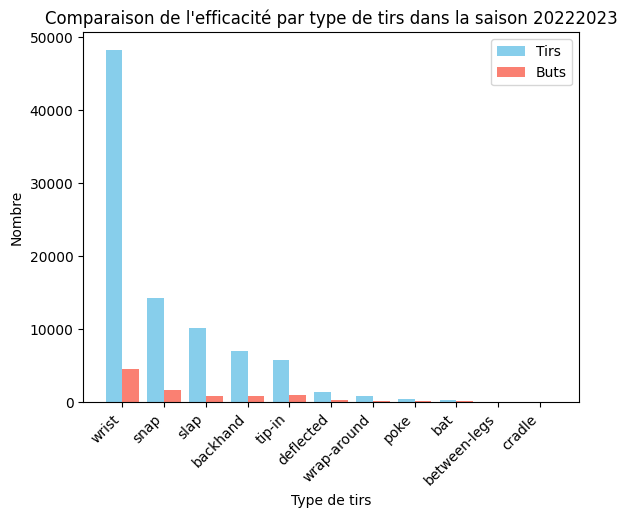

In [15]:
# Charger le fichier CSV
df = pd.read_csv('../data/nhl_play_by_play_combined3.csv')

# Sélectionner une saison spécifique (par exemple, 20222023)
saison = '20222023'

# Sélectionner les données de la saison
df_saison = df[df['season'] == int(saison)]
    
# Obtenir les différents types de tirs
types_tirs = df_saison['shotType'].unique()

# Filtrer les tirs et obtenir les comptes
comptes_tirs = df_saison['shotType'].value_counts()

# Filtrer les buts et obtenir les comptes
buts = df_saison[df_saison['eventType'] == 'goal']
comptes_buts = buts['shotType'].value_counts()

# Assurez-vous que les comptes_buts et comptes_tirs ont les mêmes indices
comptes_buts = comptes_buts.reindex(comptes_tirs.index, fill_value=0)

# Tracer les données
x = np.arange(len(comptes_tirs.index))  # Emplacements des étiquettes
largeur = 0.4  # Largeur des barres

fig, ax = plt.subplots()

# Définir des couleurs personnalisées pour les barres
couleur_tirs = 'skyblue'  # Couleur des barres pour les tirs
couleur_buts = 'salmon'   # Couleur des barres pour les buts

# Ajouter les barres avec les couleurs spécifiées
barres_tirs = ax.bar(x - largeur / 2, comptes_tirs.values, largeur, label='Tirs', color=couleur_tirs)
barres_buts = ax.bar(x + largeur / 2, comptes_buts.values, largeur, label='Buts', color=couleur_buts)

# Ajouter des étiquettes et ajustements
ax.set_ylabel('Nombre')
ax.set_xlabel('Type de tirs')
ax.set_xticks(x)
ax.set_xticklabels(comptes_tirs.index, rotation=45, horizontalalignment='right', 
                   verticalalignment='top', fontsize='medium')
ax.legend()

# Ajouter le titre du graphique
plt.title(f"Comparaison de l'efficacité par type de tirs dans la saison {saison}")
plt.savefig('../figures/comparaison_de_tirs_par_saison_20222023')
plt.show()

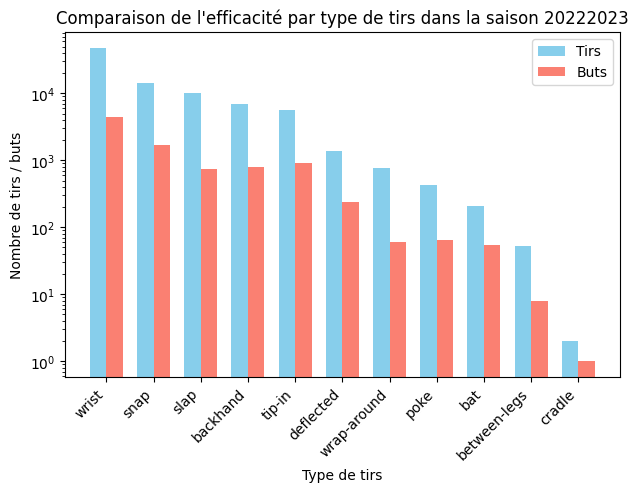

In [17]:
def tracer_tirs_buts_log(df, saison):
    # Sélectionner la saison
    df_saison = df[df['season'] == int(saison)]
    
    # Obtenir les différents types de tirs
    types_tirs = df_saison['shotType'].unique()

    # Filtrer les tirs et obtenir les comptes
    comptes_tirs = df_saison['shotType'].value_counts()

    # Filtrer les buts et obtenir les comptes
    buts = df_saison[df_saison['eventType'] == 'goal']
    comptes_buts = buts['shotType'].value_counts()

    # Assurez-vous que les comptes_buts et comptes_tirs ont les mêmes indices
    comptes_buts = comptes_buts.reindex(comptes_tirs.index, fill_value=0)

    # Tracer les données
    x = np.arange(len(comptes_tirs.index))  # Emplacements des étiquettes
    largeur = 0.35  # Largeur des barres

    fig, ax = plt.subplots()

    # Choisir les couleurs personnalisées
    couleur_tirs = 'skyblue'  # Couleur des tirs
    couleur_buts = 'salmon'   # Couleur des buts

    # Ajouter les barres avec les couleurs spécifiées
    barres_tirs = ax.bar(x - largeur / 2, comptes_tirs.values, largeur, label='Tirs', color=couleur_tirs)
    barres_buts = ax.bar(x + largeur / 2, comptes_buts.values, largeur, label='Buts', color=couleur_buts)

    # Ajouter des étiquettes et ajustements
    ax.set_ylabel('Nombre')
    ax.set_xlabel('Types de tirs')
    ax.set_xticks(x)
    ax.set_xticklabels(comptes_tirs.index, rotation=45, horizontalalignment='right', 
                       verticalalignment='top', fontsize='medium')
    ax.legend()

    # Utiliser une échelle logarithmique pour l'axe des ordonnées
    plt.yscale('log')
    fig.tight_layout()
    plt.title(f"Comparaison de l'efficacité par type de tirs dans la saison {saison}")
    plt.ylabel("Nombre de tirs / buts")
    plt.xlabel("Type de tirs")
    plt.legend()
    # Sauvegarder la figure
    plt.savefig(f'../figures/echelle_logarithmique_tirs_buts_{saison}.png')
    plt.show()

    
    

# Exécution de la fonction pour une saison spécifique
tracer_tirs_buts_log(df, '20222023')

### Le tirs plus dangereux

In [ ]:
# Calculer la proportion de buts par rapport aux tirs pour chaque type de tir
proportion_buts = comptes_buts / comptes_tirs
proportion_buts = proportion_buts.fillna(0)  # Remplir les NaN par 0 si aucun tir de ce type n'a abouti à un but

# Afficher les proportions de buts
print(proportion_buts)

### Cette dataframe df3 contient à la fois les champs 'homeTeamDefendingSide' et 'zoneCode'

In [ ]:
df3 = pd.read_csv('nhl_play_by_play_combined3.csv', dtype={10: str}, low_memory=False)

In [ ]:
import math
def distance_vs_goal(season):
    # Select the season
    df_season = df2[df2['season'] == season].reset_index()
    
    if df_season.empty:
        print(f"No data found for the season {season}.")
        return
    
    # Initialize the distance list to store calculated distances
    distances = []

    # Iterate over each row to calculate distances
    for index, row in df_season.iterrows():
        x = row['coordinateX']
        y = row['coordinateY']
        event_team_id = row['eventTeamId']
        home_team_id = row['teamHomeId']
        defending_side = row.get('homeTeamDefendingSide', None)
        zone_code = row.get('zone_code', None)

        # Check season and set calculation conditions
        if season in [20161017, 20172018, 20182019]:
            # Use zone_code for these specific seasons
            if zone_code == "D":
                if x > 0:
                    distance = math.sqrt((x + 86)**2 + y**2)
                elif x < 0:
                    distance = math.sqrt((86 - x)**2 + y**2)
            elif zone_code == "O":
                if x > 0:
                    distance = math.sqrt((86 - x)**2 + y**2)
                elif x < 0:
                    distance = math.sqrt((x + 86)**2 + y**2)
            elif zone_code == "N":
                distance = math.sqrt(86**2 + y**2)
            else:
                distance = None  # No valid case for zone_code
        
        else:
            # Use homeTeamDefendingSide for other seasons
            if event_team_id == home_team_id:
                if defending_side == "right":
                    distance = math.sqrt((x + 86)**2 + y**2)
                elif defending_side == "left":
                    distance = math.sqrt((86 - x)**2 + y**2)
                else:
                    distance = None
            else:
                if defending_side == "right":
                    distance = math.sqrt((86 - x)**2 + y**2)
                elif defending_side == "left":
                    distance = math.sqrt((x + 86)**2 + y**2)
                else:
                    distance = None
        
        
        distances.append(distance)

    # Add the calculated distances back to the DataFrame
    df_season['distance'] = distances
    df_season['distance_round'] = df_season['distance'].round(0)
    
    # Filter goals only
    df_goals_only = df_season[df_season['eventType'] == 'goal']
    
    # Calculate goal percentage by distance
    goal_score_percent_by_dist = (df_goals_only.groupby(['distance_round'])['eventType'].count() / 
                                  df_season.groupby(['distance_round'])['eventType'].count()) * 100
    
    goal_score_percent_by_dist = goal_score_percent_by_dist.rename_axis('Distance (ft)')
    goal_score_percent_by_dist = goal_score_percent_by_dist.rename('Pourcentage de buts')
    
    # Plot the graph
    sns.scatterplot(x=goal_score_percent_by_dist.index, y=goal_score_percent_by_dist)
    plt.title(f'Pourcentage de buts en fonction de la distance - Saison {season}')
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.savefig(f"../figures/goal_percent_net_dist_{season}.png")
    plt.show()
    
    return df_goals_only

In [ ]:
def calculate_distance(row, home_team_id, away_team_id, season):
    # Extraire les coordonnées
    x = row['xCoord']
    y = row['yCoord']
    event_team_id = row['eventOwnerTeamId']
    defending_side = row.get('homeTeamDefendingSide', None)
    zone_code = row.get('zoneCode', None)

    
    # Initialize the distance list to store calculated distances
    distances = []
    home_defending_side_period = {1: None, 2: None, 3: None}


    # Vérifier si l'équipe est à domicile ou à l'extérieur
    # Check season and set calculation conditions
    
    for index, row in df_season.iterrows():
        # Initialiser la distance à None pour chaque ligne
        distance = None
        
        # Extraire les informations pertinentes
        x = row['coordinateX']
        y = row['coordinateY']
        event_team_id = row['eventTeamId']
        home_team_id = row['teamHomeId']
        defending_side = row.get('homeTeamDefendingSide', None)
        zone_code = row.get('zoneCode', None)
        period = row.get('period', None)

        # Vérifier la saison et définir les conditions de calcul
        if season in [20161017, 20172018, 20182019] and zone_code is not None:
            # Utiliser zone_code pour ces saisons spécifiques
            if event_team_id == home_team_id and period in home_defending_side_period:
                # Vérifier si le côté défensif pour cette période est déjà défini
                if home_defending_side_period[period] is None:
                    # Déterminer le côté défensif en fonction de la valeur de xCoord
                    home_defending_side_period[period] = 'right' if x > 0 else 'left'
        
            # Calculer la distance en fonction du zone_code
            if zone_code == "D":
                if x > 0:
                    distance = math.sqrt((x + 89)**2 + y**2)
                elif x < 0:
                    distance = math.sqrt((89 - x)**2 + y**2)
            elif zone_code == "O":
                if x > 0:
                    distance = math.sqrt((89 - x)**2 + y**2)
                elif x < 0:
                    distance = math.sqrt((x + 89)**2 + y**2)
            elif zone_code == "N" and period in home_defending_side_period: 
                if event_team_id == home_team_id:
                    if home_defending_side_period[period] == 'right':
                        distance = math.sqrt((x + 89)**2 + y**2)
                    elif home_defending_side_period[period] == 'left':
                        distance = math.sqrt((89 - x)**2 + y**2)
                else:
                    if home_defending_side_period[period] == 'right':
                        distance = math.sqrt((89 - x)**2 + y**2)
                    elif home_defending_side_period[period] == 'left':
                        distance = math.sqrt((x + 89)**2 + y**2) 
        else:
            # Utiliser homeTeamDefendingSide pour les autres saisons
            if event_team_id == home_team_id:
                if defending_side == "right":
                    distance = math.sqrt((x + 89)**2 + y**2)
                elif defending_side == "left":
                    distance = math.sqrt((89 - x)**2 + y**2)
            else:
                if defending_side == "right":
                    distance = math.sqrt((89 - x)**2 + y**2)
                elif defending_side == "left":
                    distance = math.sqrt((x + 89)**2 + y**2)
        
        # Ajouter la distance calculée à la liste
        distances.append(distance)

    return distance


In [ ]:
def distance_vs_goal3(season):
    # Select the season
    df_season = df3[df3['season'] == season].reset_index()
    
    if df_season.empty:
        print(f"No data found for the season {season}.")
        return
    
    # Initialize the distance list to store calculated distances
    distances = []
    home_defending_side_period = {1: None, 2: None, 3: None}
    # Iterate over each row to calculate distances
    for index, row in df_season.iterrows():
        distance = None
        x = row['coordinateX']
        y = row['coordinateY']
        event_team_id = row['eventTeamId']
        home_team_id = row['teamHomeId']
        defending_side = row.get('homeTeamDefendingSide', None)
        zone_code = row.get('zoneCode', None)
        period=row.get('period', None)

        # Check season and set calculation conditions
        if season in [20161017, 20172018, 20182019] and zone_code is not None:
            # Use zone_code for these specific seasons
              
            if event_team_id == home_team_id  and period in home_defending_side_period:
            # Vérifier si le côté défensif pour cette période est déjà défini
             if home_defending_side_period[period] is None:
                   # Déterminer le côté défensif en fonction de la valeur de xCoord
                   if x> 0:
                     home_defending_side_period[period] = 'right'
                   else:
                     home_defending_side_period[period] = 'left'
        
             if zone_code == "D":
                if x > 0:
                    distance = math.sqrt((x + 89)**2 + y**2)
                elif x < 0:
                    distance = math.sqrt((89 - x)**2 + y**2)
             elif zone_code == "O":
                if x > 0:
                    distance = math.sqrt((89 - x)**2 + y**2)
                elif x < 0:
                    distance = math.sqrt((x + 89)**2 + y**2)
             elif zone_code == "N": 
                if event_team_id == home_team_id:
                 if home_defending_side_period[period] == 'right':
                      distance = math.sqrt((x + 89)**2 + y**2)
                 elif home_defending_side_period[period] == 'left':
                      distance = math.sqrt((89 - x)**2 + y**2)
                 else:
                    distance=None
                  
                else:
                 if home_defending_side_period[period] == 'right':
                      distance = math.sqrt((89 - x)**2 + y**2)
                 elif home_defending_side_period[period] == 'left':
                      distance = math.sqrt((x + 89)**2 + y**2)
                 else:
                    distance=None
              
        else:
            # Use homeTeamDefendingSide for other seasons
            if event_team_id == home_team_id:
                if defending_side == "right":
                    distance = math.sqrt((x + 89)**2 + y**2)
                elif defending_side == "left":
                    distance = math.sqrt((89 - x)**2 + y**2)
                else:
                    distance = None
            else:
                if defending_side == "right":
                    distance = math.sqrt((89 - x)**2 + y**2)
                elif defending_side == "left":
                    distance = math.sqrt((x + 89)**2 + y**2)
                else:
                    distance = None
        
    
        distances.append(distance)

    # Add the calculated distances back to the DataFrame
    df_season['distance'] = distances
    df_season['distance_round'] = df_season['distance'].round(0)
    
    # Filter goals only
    df_goals_only = df_season[df_season['eventType'] == 'goal']
    
    # Calculate goal percentage by distance
    goal_score_percent_by_dist = (df_goals_only.groupby(['distance_round'])['eventType'].count() / 
                                  df_season.groupby(['distance_round'])['eventType'].count()) * 100
    
    goal_score_percent_by_dist = goal_score_percent_by_dist.rename_axis('Distance (ft)')
    goal_score_percent_by_dist = goal_score_percent_by_dist.rename('Pourcentage de buts')
    
    # Plot the graph
    sns.scatterplot(x=goal_score_percent_by_dist.index, y=goal_score_percent_by_dist)
    plt.title(f'Pourcentage de buts en fonction de la distance - Saison {season}')
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.savefig(f"../figures/goal_percent_net_dist_{season}.png")
    plt.show()
    
    return df_goals_only

In [ ]:
def distance_vs_goal4(season):
    # Sélectionner la saison
    df_season = df3[df3['season'] == season].reset_index()
    
    if df_season.empty:
        print(f"No data found for the season {season}.")
        return
    
    # Initialiser la liste des distances et le dictionnaire des côtés défensifs par période
    distances = []
    home_defending_side_period = {1: None, 2: None, 3: None}
    
    # Boucler sur chaque ligne pour calculer les distances
    for index, row in df_season.iterrows():
        # Initialiser la distance à None pour chaque ligne
        distance = None
        
        # Extraire les informations pertinentes
        x = row['coordinateX']
        y = row['coordinateY']
        event_team_id = row['eventTeamId']
        home_team_id = row['teamHomeId']
        defending_side = row.get('homeTeamDefendingSide', None)
        zone_code = row.get('zoneCode', None)
        period = row.get('period', None)

        # Vérifier la saison et définir les conditions de calcul
        if season in [20161017, 20172018, 20182019] and zone_code is not None:
            if event_team_id == home_team_id and period in home_defending_side_period:
                if home_defending_side_period[period] is None:
                    home_defending_side_period[period] = 'right' if x > 0 else 'left'
        
            if zone_code == "D":
                if x > 0:
                    distance = math.sqrt((x + 89)**2 + y**2)
                elif x < 0:
                    distance = math.sqrt((89 - x)**2 + y**2)
            elif zone_code == "O":
                if x > 0:
                    distance = math.sqrt((89 - x)**2 + y**2)
                elif x < 0:
                    distance = math.sqrt((x + 89)**2 + y**2)
            elif zone_code == "N" and period in home_defending_side_period: 
                if event_team_id == home_team_id:
                    if home_defending_side_period[period] == 'right':
                        distance = math.sqrt((x + 89)**2 + y**2)
                    elif home_defending_side_period[period] == 'left':
                        distance = math.sqrt((89 - x)**2 + y**2)
                else:
                    if home_defending_side_period[period] == 'right':
                        distance = math.sqrt((89 - x)**2 + y**2)
                    elif home_defending_side_period[period] == 'left':
                        distance = math.sqrt((x + 89)**2 + y**2)
              
        else:
            if event_team_id == home_team_id:
                if defending_side == "right":
                    distance = math.sqrt((x + 89)**2 + y**2)
                elif defending_side == "left":
                    distance = math.sqrt((89 - x)**2 + y**2)
            else:
                if defending_side == "right":
                    distance = math.sqrt((89 - x)**2 + y**2)
                elif defending_side == "left":
                    distance = math.sqrt((x + 89)**2 + y**2)
        
        distances.append(distance)

    # Ajouter les distances calculées au DataFrame
    df_season['distance'] = distances
    
    # Filtrer pour le gameID et l'eventType spécifiés
    df_filtered = df_season[(df_season['gameId'] == 2018020366) & (df_season['eventType'] == 'goal')]
    
    # Afficher les distances filtrées
    print("Distances pour le gameID 2018020366 et l'eventType 'goal':")
    print(df_filtered[['distance', 'coordinateX', 'coordinateY', 'period']].head(20))
    
    return df_filtered

# Exécution de la fonction pour une saison spécifique
df_goals_only3 = distance_vs_goal4(20182019)

In [ ]:
df_goals_only3 = distance_vs_goal3(20182019)

In [ ]:
df_goals_only3 = distance_vs_goal3(20192020)

In [ ]:
df_goals_only3 = distance_vs_goal3(20202021)

In [ ]:
def df_goal(season):
    # Sélectionner la saison
    df_season = df[df['season'] == season].reset_index()
    
    if df_season.empty:
        print(f"No data found for the season {season}.")
        return
    
    # Initialize the distance list to store calculated distances
    distances = []
    home_defending_side_period = {1: None, 2: None, 3: None}
    
    # Iterate over each row to calculate distances
    for index, row in df_season.iterrows():
        x = row['coordinateX']
        y = row['coordinateY']
        event_team_id = row['eventTeamId']
        home_team_id = row['teamHomeId']
        defending_side = row.get('homeTeamDefendingSide', None)
        zone_code = row.get('zoneCode', None)

        zone_code = row.get('zoneCode', None)
        period = row.get('period', None)

        # Vérifier la saison et définir les conditions de calcul
        if season in [20161017, 20172018, 20182019] and zone_code is not None:
            # Utiliser zone_code pour ces saisons spécifiques
            if event_team_id == home_team_id and period in home_defending_side_period:
                # Vérifier si le côté défensif pour cette période est déjà défini
                if home_defending_side_period[period] is None:
                    # Déterminer le côté défensif en fonction de la valeur de xCoord
                    home_defending_side_period[period] = 'right' if x > 0 else 'left'
        
            # Calculer la distance en fonction du zone_code
            if zone_code == "D":
                if x > 0:
                    distance = math.sqrt((x + 89)**2 + y**2)
                elif x < 0:
                    distance = math.sqrt((89 - x)**2 + y**2)
            elif zone_code == "O":
                if x > 0:
                    distance = math.sqrt((89 - x)**2 + y**2)
                elif x < 0:
                    distance = math.sqrt((x + 89)**2 + y**2)
            elif zone_code == "N" and period in home_defending_side_period: 
                if event_team_id == home_team_id:
                    if home_defending_side_period[period] == 'right':
                        distance = math.sqrt((x + 89)**2 + y**2)
                    elif home_defending_side_period[period] == 'left':
                        distance = math.sqrt((89 - x)**2 + y**2)
                else:
                    if home_defending_side_period[period] == 'right':
                        distance = math.sqrt((89 - x)**2 + y**2)
                    elif home_defending_side_period[period] == 'left':
                        distance = math.sqrt((x + 89)**2 + y**2)
              
        else:
            # Utiliser homeTeamDefendingSide pour les autres saisons
            if event_team_id == home_team_id:
                if defending_side == "right":
                    distance = math.sqrt((x + 89)**2 + y**2)
                elif defending_side == "left":
                    distance = math.sqrt((89 - x)**2 + y**2)
            else:
                if defending_side == "right":
                    distance = math.sqrt((89 - x)**2 + y**2)
                elif defending_side == "left":
                    distance = math.sqrt((x + 89)**2 + y**2)
        
        # Ajouter la distance calculée à la liste
        distances.append(distance)

    # Ajouter les distances calculées au DataFrame
    df_season['distance'] = distances
    df_season['distance_round'] = df_season['distance'].round(0)
    
    # Add the calculated distances back to the DataFrame
    df_season['distance'] = distances
    df_season['distance_round'] = df_season['distance'].round(0)
    
    # Filtrer uniquement les buts
    df_goals_only = df_season[df_season['eventType'] == 'goal']
    
    # Calculer le pourcentage de buts par distance
    goal_score_percent_by_dist = (df_goals_only.groupby(['distance_round'])['eventType'].count() / 
                                  df_season.groupby(['distance_round'])['eventType'].count()) * 100
    
    goal_score_percent_by_dist = goal_score_percent_by_dist.rename_axis('Distance (ft)')
    goal_score_percent_by_dist = goal_score_percent_by_dist.rename('Pourcentage de buts')
    
   
    return df_season, df_goals_only

In [ ]:
# Charger le fichier CSV
df = pd.read_csv('../data/nhl_play_by_play_combined3.csv')
df_season,df_goals_only=df_goal(20222023)
print(df_season.columns)
print(df_goals_only.columns)

In [ ]:
def distance_pourcentage_buts_type_tirs(saison):
    df_saison, df_buts_seulement = df_goal(saison)
    
    # Calcul du pourcentage de buts par distance et type de tir
    pourcentage_buts_par_distance_et_tir = (
        df_buts_seulement.groupby(['distance_round', 'shotType'])['eventType'].count() / 
        df_saison.groupby(['distance_round', 'shotType'])['eventType'].count()
    ) * 100

    # Nettoyer et renommer les colonnes pour les rendre plus lisibles
    pourcentage_buts_par_distance_et_tir = pourcentage_buts_par_distance_et_tir.reset_index().dropna()
    pourcentage_buts_par_distance_et_tir = pourcentage_buts_par_distance_et_tir.rename(
        columns={'eventType': 'Pourcentage de buts', 
                 'distance_round': 'Distance (pieds)', 
                 'shotType': 'Type de tir'}
    )
    
    # Création du graphique
    plt.figure(figsize=(20, 10))
    plt.rcParams["axes.labelsize"] = 16    
    plt.rcParams.update({'font.size': 16})
    
    ax = sns.relplot(
        x=pourcentage_buts_par_distance_et_tir['Distance (pieds)'], 
        y=pourcentage_buts_par_distance_et_tir['Pourcentage de buts'], 
        col=pourcentage_buts_par_distance_et_tir['Type de tir'],
        col_wrap=3,
    )

    # Ajouter le titre principal
    plt.suptitle(f'Pourcentage de buts (tirs/buts) en fonction de la distance et du type de tir - {saison}', fontsize=16)
    
    # Ajustement de la mise en page et sauvegarde
    ax.fig.subplots_adjust(top=0.9)
    ax.tight_layout()
    plt.savefig(f'../figures/pourcentage_buts_vs_distance_type_tir{saison}.png')

    return None

In [ ]:
distance_pourcentage_buts_type_tirs(20202021)

In [ ]:
# Calculer la proportion de buts par rapport aux tirs pour chaque type de tir
df_saison, df_buts_seulement = df_goal(20202021)
    
    # Calcul du pourcentage de buts par distance et type de tir
pourcentage_buts_par_distance_et_tir = (
        df_buts_seulement.groupby(['distance_round', 'shotType'])['eventType'].count() / 
        df_saison.groupby(['distance_round', 'shotType'])['eventType'].count()
    ) * 100

    # Nettoyer et renommer les colonnes pour les rendre plus lisibles
pourcentage_buts_par_distance_et_tir = pourcentage_buts_par_distance_et_tir.reset_index().dropna()
print(pourcentage_buts_par_distance_et_tir)

### Le eventType qui donne le pourcentage max des buts par distance

In [ ]:
# Supposons que df_saison et df_buts_seulement soient déjà définis
df_saison, df_buts_seulement = df_goal(20202021)

# Calcul du pourcentage de buts par distance et type de tir
pourcentage_buts_par_distance_et_tir = (
    df_buts_seulement.groupby(['distance_round', 'shotType'])['eventType'].count() / 
    df_saison.groupby(['distance_round', 'shotType'])['eventType'].count()
) * 100

# Nettoyer et renommer les colonnes pour les rendre plus lisibles
pourcentage_buts_par_distance_et_tir = pourcentage_buts_par_distance_et_tir.reset_index().dropna()

# Ajouter une colonne pour les intervalles de distance
def assign_distance_interval(distance):
    if distance < 30:
        return '0-30'
    elif distance < 60:
        return '30-60'
    elif distance < 90:
        return '60-90'
    elif distance < 120:
        return '90-120'
    elif distance < 150:
        return '120-150'
    elif distance <= 180:
        return '150-180'
    else:
        return '180+'

pourcentage_buts_par_distance_et_tir['intervalle_distance'] = pourcentage_buts_par_distance_et_tir['distance_round'].apply(assign_distance_interval)

# Calculer la moyenne des pourcentages de buts par type de tir et par intervalle de distance
moyennes_par_intervalle = pourcentage_buts_par_distance_et_tir.groupby(['intervalle_distance', 'shotType'])['eventType'].mean().reset_index()
moyennes_par_intervalle = moyennes_par_intervalle.rename(columns={'eventType': 'Moyenne Pourcentage de Buts'})

# Affichage des résultats
#print(moyennes_par_intervalle)

# Tri des données par ordre croissant des intervalles de distance et en fonction du pourcentage de buts
moyennes_par_intervalle = moyennes_par_intervalle.sort_values(by=['intervalle_distance', 'Moyenne Pourcentage de Buts'], ascending=[True, False])

# Filtrer pour garder uniquement le type de tir ayant le pourcentage de buts le plus élevé dans chaque intervalle
max_pourcentage_par_intervalle = moyennes_par_intervalle.groupby('intervalle_distance').first().reset_index()

# Afficher le résultat
print(max_pourcentage_par_intervalle)

### Le eventType qui donne le pourcentage min des buts par distance

In [ ]:
# Trier les données par intervalle de distance et pourcentage de buts en ordre croissant
moyennes_par_intervalle = moyennes_par_intervalle.sort_values(by=['intervalle_distance', 'Moyenne Pourcentage de Buts'])

# Extraire le type de tir avec le pourcentage de buts minimum pour chaque intervalle de distance
min_pourcentage_par_intervalle = moyennes_par_intervalle.groupby('intervalle_distance').first().reset_index()

# Afficher le eventype qui donne le pourcentage min des buts
print(min_pourcentage_par_intervalle)

In [ ]:
def distance_vs_goal_percent_vs_shot_types_violinplot(season):
    df_saison, df_buts_seulement = df_goal(saison)
    df_season = df_saison.reset_index()
    
    fig, ax = plt.subplots(figsize=(10,6.5))
    plt.axis('on')

    ax = sns.violinplot(x="shotType", y="distance", hue="eventType",
                data=df_season, palette="viridis", split=True)
    plt.title(f'Violin Plot of Shots vs Goals by Shot Type and Distance from Net \n ({season} - {season+1})')
    plt.xlabel('Shot Type')
    plt.ylabel('Distance (ft)')
    
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + 
                     ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.savefig(f'../figures/violin_goal_percent_v_dist_{season}')

distance_vs_goal_percent_vs_shot_types_violinplot(20202021)

### Le pLot KDE pour la distribution des pourcentages de buts par distance

In [ ]:
df_saison, df_buts_seulement = df_goal(20212022)
print(df_saison.columns)

In [ ]:
def distance_vs_pourcentage_but_vs_types_tirs_kdeplot(saison):

    # Supposons que df_saison et df_buts_seulement soient déjà définis
    df_saison, df_buts_seulement = df_goal(20202021)
    
    pourcentage_buts_par_distance = (df_buts_seulement.groupby(['distance', 'shotType'])['eventType'].count() / 
        df_saison.groupby(['distance', 'shotType'])['eventType'].count() ) * 100
    
    pourcentage_buts_par_distance = pourcentage_buts_par_distance.reset_index().dropna()
    pourcentage_buts_par_distance = pourcentage_buts_par_distance.rename(columns={'eventType': 'Pourcentage de Buts',
                                                                                  'distance': 'Distance (pieds)',
                                                                                  'shotType': 'Type de Tir'})
    
    types_tirs = pourcentage_buts_par_distance['Type de Tir'].unique()
    fig, axs = plt.subplots(3,3, figsize=(20, 15), constrained_layout=True)
    plt.axis('on')
    
    for i, tir in enumerate(types_tirs):
        sous_ensemble = pourcentage_buts_par_distance[pourcentage_buts_par_distance['Type de Tir'] == tir]
        i, j = int(i/3), i%3
    
        sns.kdeplot(ax=axs[i, j], data=sous_ensemble, x='Distance (pieds)', y='Pourcentage de Buts', 
                    hue_norm=(0,100), bw_adjust=.2, fill=True, palette='crest')
        axs[i, j].title.set_text(tir)
        axs[i, j].set_xlim([0,200])
        axs[i, j].set_ylim([0,100])
        axs[-1, -1].axis('off')
        axs[-1, -2].axis('off')
        
        for item in ([axs[i,j].title, axs[i,j].xaxis.label, axs[i,j].yaxis.label] + 
                     axs[i,j].get_xticklabels() + axs[i,j].get_yticklabels()):
            item.set_fontsize(20)
    
    fig.suptitle(f'Diagramme de densité du pourcentage de buts vs distance par type de tir \n ({saison})', fontsize=24)
    fig.tight_layout()
    plt.savefig(f'../figures/densite_pourcentage_buts_v_dist_{saison}')

In [ ]:
def distance_vs_pourcentage_but_vs_types_tirs_kdeplot(saison):

    # Supposons que df_saison et df_buts_seulement soient déjà définis
    df_saison, df_buts_seulement = df_goal(20202021)
    
    pourcentage_buts_par_distance = (df_buts_seulement.groupby(['distance', 'shotType'])['eventType'].count() / 
        df_saison.groupby(['distance', 'shotType'])['eventType'].count() ) * 100
    
    pourcentage_buts_par_distance = pourcentage_buts_par_distance.reset_index().dropna()
    pourcentage_buts_par_distance = pourcentage_buts_par_distance.rename(columns={'eventType': 'Pourcentage de Buts',
                                                                                  'distance': 'Distance (pieds)',
                                                                                  'shotType': 'Type de Tir'})
    
    types_tirs = pourcentage_buts_par_distance['Type de Tir'].unique()
    fig, axs = plt.subplots(3, 3, figsize=(20, 15), constrained_layout=True)
    plt.axis('on')
    
    # Colormap personnalisé
    colormap = plt.get_cmap('plasma')  # Vous pouvez essayer 'magma', 'plasma', 'inferno', 'viridis', etc.
    
    for i, tir in enumerate(types_tirs):
        sous_ensemble = pourcentage_buts_par_distance[pourcentage_buts_par_distance['Type de Tir'] == tir]
        i, j = int(i/3), i%3
    
        # Utilisation de 'cmap' au lieu de 'palette' pour KDE
        sns.kdeplot(ax=axs[i, j], data=sous_ensemble, x='Distance (pieds)', y='Pourcentage de Buts', 
                    hue_norm=(0, 100), bw_adjust=.2, fill=True, cmap=colormap)  # Appliquez cmap ici
        axs[i, j].title.set_text(tir)
        axs[i, j].set_xlim([0, 200])
        axs[i, j].set_ylim([0, 100])
        axs[-1, -1].axis('off')
        axs[-1, -2].axis('off')
        
        for item in ([axs[i, j].title, axs[i, j].xaxis.label, axs[i, j].yaxis.label] + 
                     axs[i, j].get_xticklabels() + axs[i, j].get_yticklabels()):
            item.set_fontsize(20)
    
    fig.suptitle(f'Diagramme de densité du pourcentage de buts vs distance par type de tir \n ({saison})', fontsize=24)
    fig.tight_layout()
    plt.savefig(f'../figures/densite_pourcentage_buts_v_dist_{saison}')
    plt.show()

In [ ]:
distance_vs_pourcentage_but_vs_types_tirs_kdeplot(20202021)